In [1]:
import pandas as pd
import numpy as np
import arrow
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor

In [2]:
id = 1
df = pd.read_csv('USvideos.csv')
df_24 = df[df['category_id'] == id]

index = int(len(df_24)*0.8)
df_train =df_24[:index]
df_test = df_24[index:]

X_train = df_train[["likes"]].to_numpy()
Y_train = df_train["views"].to_numpy()
X_test = df_test[["likes"]].to_numpy()
Y_test = df_test["views"].to_numpy()

In [3]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [4]:
Y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print("MSE: %.2f" % mse)
print("R2 Score: %.2f" % r2)



MSE: 18220661463127.03
R2 Score: 0.74


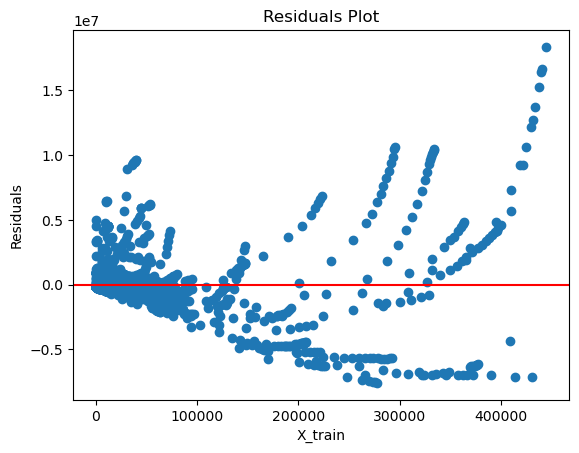

In [5]:
Y_train_pred = model.predict(X_train)

residuals = Y_train - Y_train_pred
studentized_residuals = residuals / np.sqrt(mean_squared_error(Y_train, Y_train_pred))
outliers = np.abs(studentized_residuals) > 2
plt.scatter(X_train, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('X_train')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [6]:
cook_distance = (residuals ** 2) / (model.coef_ ** 2 * X_train.var())
outliers_cooks = cook_distance > 4 / len(X_train[0])

print("Outliers based on studentized residuals:", np.where(outliers)[0])
print("Outliers based on Cook's distance:", np.where(outliers_cooks)[0])

outliers_indices = np.where(outliers)[0]


Outliers based on studentized residuals: [ 103  115  129  142  155  248  687  701  718  728  735  752  764  788
  804  818  829  845  857  929  938  951  965  966  980  981  994  995
  997 1008 1009 1010 1021 1022 1023 1038 1055 1072 1079 1080 1082 1086
 1092 1094 1097 1102 1104 1107 1112 1114 1116 1120 1123 1124 1129 1132
 1134 1139 1143 1150 1154 1164 1176 1228 1237 1239 1241 1249 1253 1254
 1261 1265 1266 1273 1277 1278 1285 1289 1290 1302 1303 1317 1318 1331
 1333 1345 1347 1362 1364 1375 1388 1401 1415 1520 1529 1537 1538 1545
 1546 1553 1554 1564 1565 1574 1588 1601 1614 1626 1639 1653 1657 1668
 1673 1687 1701 1715 1727 1738 1749 1760 1771 1783 1784 1786 1795 1798
 1800 1812 1814 1827 1841 1853 1860 1865 1871]
Outliers based on Cook's distance: [ 115  129  142  155  752  764  929  938  951  966  981  995 1009 1022
 1092 1102 1112 1120 1124 1129 1134 1139 1143 1150 1154 1164 1176 1278
 1290 1303 1318 1333 1347 1364 1687 1701 1715 1727 1738 1749 1760 1771
 1783 1795]


In [7]:
cleaned_X = np.delete(X_train, outliers_indices, axis=0)
cleaned_y = np.delete(Y_train, outliers_indices, axis=0)

model.fit(cleaned_X, cleaned_y)
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print("new MSE: %.2f" % mse)
print("new R2 Score: %.2f" % r2)

new MSE: 18726305713353.25
new R2 Score: 0.74


In [8]:
outliers_indices_Cook = np.where(outliers_cooks)[0]

cleaned_X_Cook = np.delete(X_train, outliers_indices_Cook, axis=0)
cleaned_y_Cook = np.delete(Y_train, outliers_indices_Cook, axis=0)

model.fit(cleaned_X_Cook, cleaned_y_Cook)
Y_pred_cook = model.predict(X_test)
mse_Cook = mean_squared_error(Y_test, Y_pred_cook)
r2_Cook = r2_score(Y_test, Y_pred_cook)
print("new MSE: %.2f" % mse_Cook)
print("new R2 Score: %.2f" % r2_Cook)

new MSE: 21666584879483.34
new R2 Score: 0.70


In [9]:
all_outliers_indices = np.union1d(outliers_indices, outliers_indices_Cook)

df_10_cleaned = df_24.drop(df_24.index[all_outliers_indices])

df.update(df_10_cleaned)

df = df[df.index.isin(df_10_cleaned.index) & (df['category_id'] == 10)]

df.to_csv(f'USvideos_cleaned_{id}.csv', index=False)

In [10]:
def standardize_trending_date(date_str):
    try:
        date = pd.to_datetime(date_str, format='%y.%d.%m')
        return date.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

def standardize_publish_time(date_str):
    try:
        date = pd.to_datetime(date_str, format='%Y-%m-%d')
        return date.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

In [11]:
df_10_cleaned['trending_date'] = df_10_cleaned['trending_date'].apply(standardize_trending_date)
df_10_cleaned['publish_time'] = df_10_cleaned['publish_time'].apply(standardize_publish_time)

In [12]:

time_series_10 = df_10_cleaned.groupby(['trending_date']).size().reset_index(name = 'counts')
print(time_series_10)

    trending_date  counts
0      2017-11-14       8
1      2017-11-15      10
2      2017-11-16      12
3      2017-11-17      10
4      2017-11-18       9
..            ...     ...
200    2018-06-10      16
201    2018-06-11      16
202    2018-06-12      16
203    2018-06-13      15
204    2018-06-14      15

[205 rows x 2 columns]


In [13]:
iddf = pd.read_csv('US_category_id.csv')

category_dict = pd.Series(iddf.title.values, index=iddf.id).to_dict()

In [14]:
from statsmodels.tsa.arima.model import ARIMA
forecast_results = {}

In [15]:
category_data = time_series_10[:-20]

In [16]:
print(category_data)

    trending_date  counts
0      2017-11-14       8
1      2017-11-15      10
2      2017-11-16      12
3      2017-11-17      10
4      2017-11-18       9
..            ...     ...
180    2018-05-21      12
181    2018-05-22      10
182    2018-05-23      10
183    2018-05-24      10
184    2018-05-25      10

[185 rows x 2 columns]


d:\Anaconda\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Anaconda\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Anaconda\envs\tensorflow_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


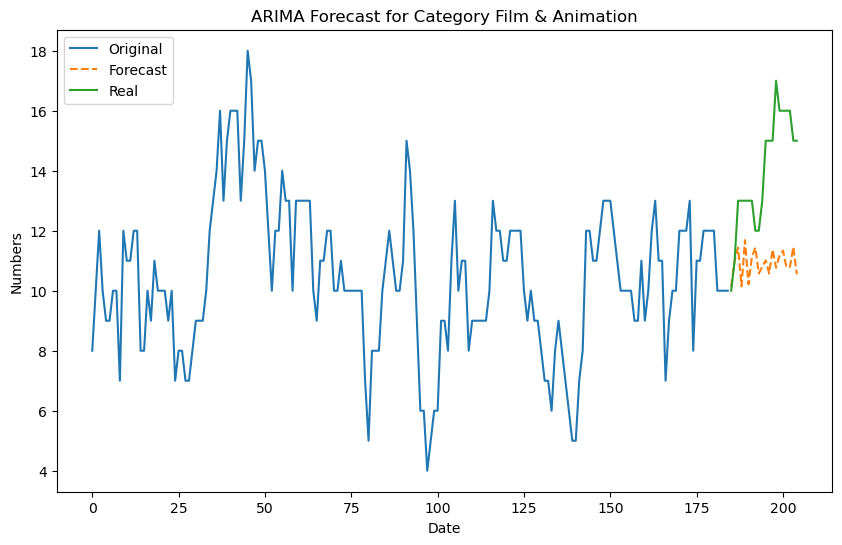

In [25]:
from matplotlib.ticker import MaxNLocator
category_data = time_series_10[:-20]
    
ts = category_data['counts']
original_ts = time_series_10['counts'][-20:]
model = ARIMA(ts, order=(30, 3, 1))
model_fit = model.fit()
    
forecast = model_fit.forecast(steps=20)

plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.plot(original_ts, label='Real')
plt.title(f'ARIMA Forecast for Category {category_dict[id]}')
plt.xlabel('Date')
plt.ylabel('Numbers')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))

plt.legend()
plt.show()